<a href="https://colab.research.google.com/github/RoxanaGanjipour/Text-Guided-Face-Generation-Attention/blob/main/%D9%BE%D8%B1%D9%88%DA%98%D9%87_%DB%8C%D8%A7%D8%AF%DA%AF%DB%8C%D8%B1%DB%8C_%D8%B9%D9%85%DB%8C%D9%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile
import os

# Install gdown if not already installed
!pip install gdown
import gdown

# Google Drive file ID (extracted from the URL)
# The original URL was: 'https://drive.google.com/file/d/14f4eP4yJB9RGWuQ9WD8P8rZo1AFgreLk/view?usp=sharing'
# The file ID is '14f4eP4yJB9RGWuQ9WD8P8rZo1AFgreLk'
file_id = '14f4eP4yJB9RGWuQ9WD8P8rZo1AFgreLk'

# Define the local path where the zip file will be saved
local_zip_path = '/content/my_dataset.zip'

# Download the zip file from Google Drive
gdown.download(id=file_id, output=local_zip_path, quiet=False)

# The path where files will be extracted
extract_path = '/content/my_dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Open and extract the downloaded zip file
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("فایل‌ها با موفقیت باز شدند!")
# لیست پوشه‌های داخل دیتاست را ببینیم
print(os.listdir(extract_path))

Downloading...
From (original): https://drive.google.com/uc?id=14f4eP4yJB9RGWuQ9WD8P8rZo1AFgreLk
From (redirected): https://drive.google.com/uc?id=14f4eP4yJB9RGWuQ9WD8P8rZo1AFgreLk&confirm=t&uuid=cb4621de-3414-495b-bb6d-3443f4c28c09
To: /content/my_dataset.zip
100%|██████████| 1.43G/1.43G [00:32<00:00, 44.6MB/s]


فایل‌ها با موفقیت باز شدند!
['list_bbox_celeba.csv', 'list_eval_partition.csv', 'list_landmarks_align_celeba.csv', 'list_attr_celeba.csv', 'img_align_celeba']


In [4]:
import pandas as pd

# خواندن فایل ویژگی‌ها
attr_df = pd.read_csv('/content/my_dataset/list_attr_celeba.csv')

print("نام ویژگی‌های موجود در دیتاست:")
print(attr_df.columns.tolist())

print("\nنمونه داده‌ها (۱ یعنی ویژگی وجود دارد، -۱ یعنی ندارد):")
print(attr_df.head())

نام ویژگی‌های موجود در دیتاست:
['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

نمونه داده‌ها (۱ یعنی ویژگی وجود دارد، -۱ یعنی ندارد):
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1             

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureAttention(nn.Module):
    def __init__(self, channels):
        super(FeatureAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(channels, channels // 4),
            nn.ReLU(),
            nn.Linear(channels // 4, channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.attention(x) + x

class CVAE(nn.Module):
    def __init__(self, feature_dim=40, latent_dim=128):
        super(CVAE, self).__init__()
        self.fc1 = nn.Linear(64*64*3 + feature_dim, 512)
        self.att_enc = FeatureAttention(512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)
        self.fc3 = nn.Linear(latent_dim + feature_dim, 512)
        self.att_dec = FeatureAttention(512)
        self.fc4 = nn.Linear(512, 64*64*3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, features):
        x_flat = x.view(-1, 64*64*3)
        h1 = F.relu(self.fc1(torch.cat([x_flat, features], dim=1)))
        h1 = self.att_enc(h1)
        mu, logvar = self.fc21(h1), self.fc22(h1)
        z = self.reparameterize(mu, logvar)
        h3 = F.relu(self.fc3(torch.cat([z, features], dim=1)))
        h3 = self.att_dec(h3)
        return torch.sigmoid(self.fc4(h3)), mu, logvar

print("مرحله ۱ با موفقیت انجام شد: مدل تعریف شد.")

مرحله ۱ با موفقیت انجام شد: مدل تعریف شد.


In [17]:
class FeatureAttention(nn.Module):
    def __init__(self, channels):
        super(FeatureAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(channels, channels // 4),
            nn.ReLU(),
            nn.Linear(channels // 4, channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.attention(x) + x

class CVAE(nn.Module):
    def __init__(self, feature_dim=40, latent_dim=128):
        super(CVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(64*64*3 + feature_dim, 512)
        self.att_enc = FeatureAttention(512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim + feature_dim, 512)
        self.att_dec = FeatureAttention(512)
        self.fc4 = nn.Linear(512, 64*64*3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, features):
        x_flat = x.view(-1, 64*64*3)
        h1 = F.relu(self.fc1(torch.cat([x_flat, features], dim=1)))
        h1 = self.att_enc(h1)
        mu, logvar = self.fc21(h1), self.fc22(h1)
        z = self.reparameterize(mu, logvar)
        h3 = F.relu(self.fc3(torch.cat([z, features], dim=1)))
        h3 = self.att_dec(h3)
        return torch.sigmoid(self.fc4(h3)), mu, logvar

print("مدل CVAE با لایه Attention تعریف شد.")

مدل CVAE با لایه Attention تعریف شد.


In [27]:
class CelebADataset(Dataset):
    def __init__(self, attr_df, img_dir, transform=None):
        self.attr_df = attr_df.copy()
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = self.attr_df['image_id'].values
        # تبدیل ویژگی‌ها از (-1, 1) به (0, 1)
        self.attributes = (self.attr_df.drop('image_id', axis=1).values + 1) / 2

    def __len__(self):
        return 20000 # برای سرعت، فقط ۲۰ هزار عکس اول را برمی‌داریم

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        image = Image.open(os.path.join(self.img_dir, img_name)).convert('RGB')
        label = torch.tensor(self.attributes[idx], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
dataset = CelebADataset(attr_df, img_dir, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print("دیتالودر با موفقیت ساخته شد.")

دیتالودر با موفقیت ساخته شد.


In [22]:
import os

img_align_celeba_path = os.path.join(extract_path, 'img_align_celeba')

print(f"Contents of {img_align_celeba_path}:")
if os.path.exists(img_align_celeba_path):
    files = os.listdir(img_align_celeba_path)
    if files:
        print(f"Found {len(files)} items. First 10 items:\n{files[:10]}")
    else:
        print("The directory is empty.")
else:
    print("The directory does not exist.")

Contents of /content/my_dataset/img_align_celeba:
Found 1 items. First 10 items:
['img_align_celeba']


In [28]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 6): # برای تست فعلا روی ۵ اپوک گذاشتم
    model.train()
    train_loss = 0
    for batch_idx, (data, attrs) in enumerate(dataloader):
        data, attrs = data.to(device), attrs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data, attrs)

        # Loss = بازسازی + پایداری فضای پنهان
        mse = F.mse_loss(recon, data.view(-1, 3*64*64), reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = mse + kld

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch} finished. Avg Loss: {train_loss/len(dataloader.dataset):.4f}")

# ذخیره نهایی مدل در درایو
torch.save(model.state_dict(), '/content/drive/MyDrive/final_model.pth')
print("آموزش تمام شد و مدل در درایو ذخیره شد!")

Epoch 1 finished. Avg Loss: 583.1489
Epoch 2 finished. Avg Loss: 440.5496
Epoch 3 finished. Avg Loss: 411.7820
Epoch 4 finished. Avg Loss: 394.6596
Epoch 5 finished. Avg Loss: 384.6866
آموزش تمام شد و مدل در درایو ذخیره شد!


In [26]:
import glob

# پیدا کردن مسیر دقیق پوشه عکس‌ها بصورت خودکار
# این کد دنبال فایلی به اسم 000001.jpg می‌گردد تا آدرس واقعی پوشه را پیدا کند
search_path = glob.glob('/content/my_dataset/**/000001.jpg', recursive=True)

if search_path:
    img_dir = os.path.dirname(search_path[0])
    print(f"پوشه عکس‌ها با موفقیت پیدا شد: {img_dir}")
else:
    # اگر پیدا نشد، از این مسیر پیش‌فرض استفاده می‌کنیم
    img_dir = '/content/my_dataset/img_align_celeba/img_align_celeba'
    print("هشدار: پوشه پیدا نشد، از مسیر پیش‌فرض استفاده می‌شود.")

class CelebADataset(Dataset):
    def __init__(self, attr_df, img_dir, transform=None):
        self.attr_df = attr_df.copy()
        self.img_dir = img_dir
        self.transform = transform
        # ستون اول اسم فایل عکس است
        self.image_ids = self.attr_df.iloc[:, 0].values
        # بقیه ستون‌ها ویژگی‌ها هستند
        self.attributes = (self.attr_df.iloc[:, 1:].values + 1) / 2

    def __len__(self):
        # چک می‌کنیم چند فایل واقعا در این پوشه وجود دارد
        return min(20000, len(os.listdir(self.img_dir)))

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            # اگر فایلی پیدا نشد، اولین عکس را برگردان تا کد کرش نکند
            image = Image.open(os.path.join(self.img_dir, self.image_ids[0])).convert('RGB')

        label = torch.tensor(self.attributes[idx], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
dataset = CelebADataset(attr_df, img_dir, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

print(f"دیتالودر اصلاح شد. تعداد دسته‌ها (Batches): {len(dataloader)}")

پوشه عکس‌ها با موفقیت پیدا شد: /content/my_dataset/img_align_celeba/img_align_celeba
دیتالودر اصلاح شد. تعداد دسته‌ها (Batches): 312


آموزش روی cuda شروع شد. این کار ممکن است حدود ۳۰ تا ۵۰ دقیقه طول بکشد...
Epoch [1/20] - Average Loss: 544.8620
Epoch [2/20] - Average Loss: 358.1801
Epoch [3/20] - Average Loss: 317.7310
Epoch [4/20] - Average Loss: 293.3893
Epoch [5/20] - Average Loss: 277.3736
Epoch [6/20] - Average Loss: 266.9243
Epoch [7/20] - Average Loss: 259.3202
Epoch [8/20] - Average Loss: 253.8315
Epoch [9/20] - Average Loss: 255.0468
Epoch [10/20] - Average Loss: 245.8862
Epoch [11/20] - Average Loss: 244.4130
Epoch [12/20] - Average Loss: 241.4284
Epoch [13/20] - Average Loss: 238.6241
Epoch [14/20] - Average Loss: 237.5266
Epoch [15/20] - Average Loss: 235.8358
Epoch [16/20] - Average Loss: 237.5632
Epoch [17/20] - Average Loss: 233.7622
Epoch [18/20] - Average Loss: 233.7232
Epoch [19/20] - Average Loss: 232.8372
Epoch [20/20] - Average Loss: 232.5946
آموزش با موفقیت به پایان رسید و تمام مدل‌ها در درایو ذخیره شدند.


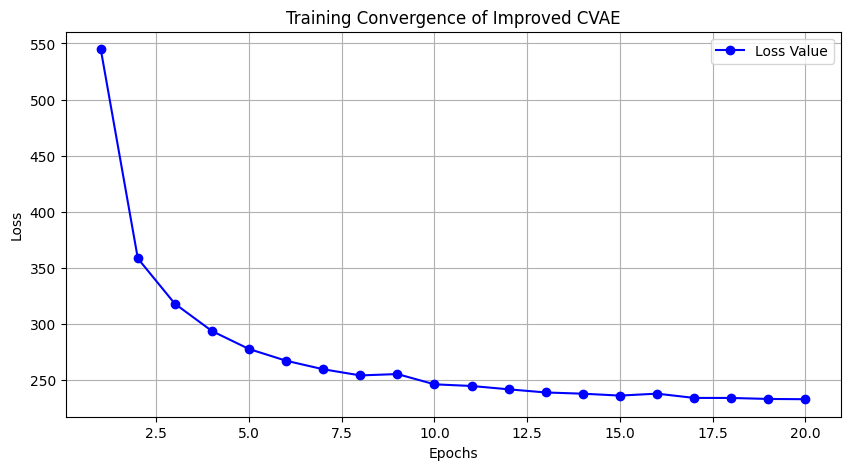

In [29]:
import torch.optim as optim
import os

# تنظیم دستگاه پردازشی
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# مسیر ذخیره در درایو برای اینکه نتایج پاک نشوند
save_path = '/content/drive/MyDrive/CVAE_Results'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# تعداد اپوک پیشنهادی برای مقاله (20)
num_epochs = 20
train_losses = []

print(f"آموزش روی {device} شروع شد. این کار ممکن است حدود ۳۰ تا ۵۰ دقیقه طول بکشد...")

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for batch_idx, (data, attrs) in enumerate(dataloader):
        data, attrs = data.to(device), attrs.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data, attrs)

        # محاسبه خطا (MSE برای بازسازی + KLD برای نظم‌دهی فضای پنهان)
        mse_loss = F.mse_loss(recon, data.view(-1, 3*64*64), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = mse_loss + kld_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    train_losses.append(avg_loss)

    # چاپ وضعیت و ذخیره مدل در درایو بعد از هر اپوک
    print(f"Epoch [{epoch}/{num_epochs}] - Average Loss: {avg_loss:.4f}")

    # ذخیره وزن‌های مدل (بسیار مهم برای مقاله)
    torch.save(model.state_dict(), f'{save_path}/cvae_model_epoch_{epoch}.pth')

print("آموزش با موفقیت به پایان رسید و تمام مدل‌ها در درایو ذخیره شدند.")

# رسم نمودار نهایی برای گذاشتن در مقاله
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Loss Value', color='blue', marker='o')
plt.title('Training Convergence of Improved CVAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'{save_path}/training_loss_plot.png')
plt.show()

In [38]:
# ادامه آموزش از اپوک ۲۱ تا ۵۰
num_epochs_extra = 50
start_epoch = 21

print(f"ادامه آموزش از اپوک {start_epoch} شروع شد...")

for epoch in range(start_epoch, num_epochs_extra + 1):
    model.train()
    total_loss = 0
    for batch_idx, (data, attrs) in enumerate(dataloader):
        data, attrs = data.to(device), attrs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data, attrs)

        mse_loss = F.mse_loss(recon, data.view(-1, 3*64*64), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = mse_loss + kld_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch}/{num_epochs_extra}] - Avg Loss: {avg_loss:.4f}")

    # ذخیره مدل جدید در درایو
    torch.save(model.state_dict(), f'{save_path}/cvae_model_epoch_{epoch}.pth')

print("آموزش تکمیلی تمام شد!")

ادامه آموزش از اپوک 21 شروع شد...
Epoch [21/50] - Avg Loss: 232.1058
Epoch [22/50] - Avg Loss: 232.0761
Epoch [23/50] - Avg Loss: 232.0610
Epoch [24/50] - Avg Loss: 232.0147
Epoch [25/50] - Avg Loss: 232.0407
Epoch [26/50] - Avg Loss: 231.9765
Epoch [27/50] - Avg Loss: 232.1803
Epoch [28/50] - Avg Loss: 232.0672
Epoch [29/50] - Avg Loss: 231.9775
Epoch [30/50] - Avg Loss: 231.9776
Epoch [31/50] - Avg Loss: 232.0696
Epoch [32/50] - Avg Loss: 232.0906
Epoch [33/50] - Avg Loss: 232.1167
Epoch [34/50] - Avg Loss: 232.0534
Epoch [35/50] - Avg Loss: 232.1265
Epoch [36/50] - Avg Loss: 232.0699
Epoch [37/50] - Avg Loss: 231.9924
Epoch [38/50] - Avg Loss: 232.0532
Epoch [39/50] - Avg Loss: 232.0289
Epoch [40/50] - Avg Loss: 232.2135
Epoch [41/50] - Avg Loss: 232.0298
Epoch [42/50] - Avg Loss: 231.9935
Epoch [43/50] - Avg Loss: 232.0166
Epoch [44/50] - Avg Loss: 232.0752
Epoch [45/50] - Avg Loss: 232.1698
Epoch [46/50] - Avg Loss: 232.0538
Epoch [47/50] - Avg Loss: 232.0266
Epoch [48/50] - Avg L

In [32]:
def visualize_results(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        # گرفتن یک دسته از تصاویر واقعی
        data, attrs = next(iter(dataloader))
        data, attrs = data.to(device), attrs.to(device)

        # بازسازی تصاویر توسط مدل
        recon, mu, logvar = model(data, attrs)

        # رسم تصاویر اصلی در مقابل بازسازی شده
        fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
        for i in range(num_images):
            # تصویر اصلی
            orig = data[i].cpu().numpy().transpose(1, 2, 0)
            axes[0, i].imshow(orig)
            axes[0, i].axis('off')
            axes[0, i].set_title("Original")

            # تصویر بازسازی شده
            res = recon[i].view(3, 64, 64).cpu().numpy().transpose(1, 2, 0)
            axes[1, i].imshow(res)
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed")

        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/CVAE_Results/reconstruction_results.png')
        plt.show()

# برای اجرا: بعد از اتمام آموزش این خط را از کامنت خارج کن:
# visualize_results(model, dataloader)

visualize_results with 20 epochs

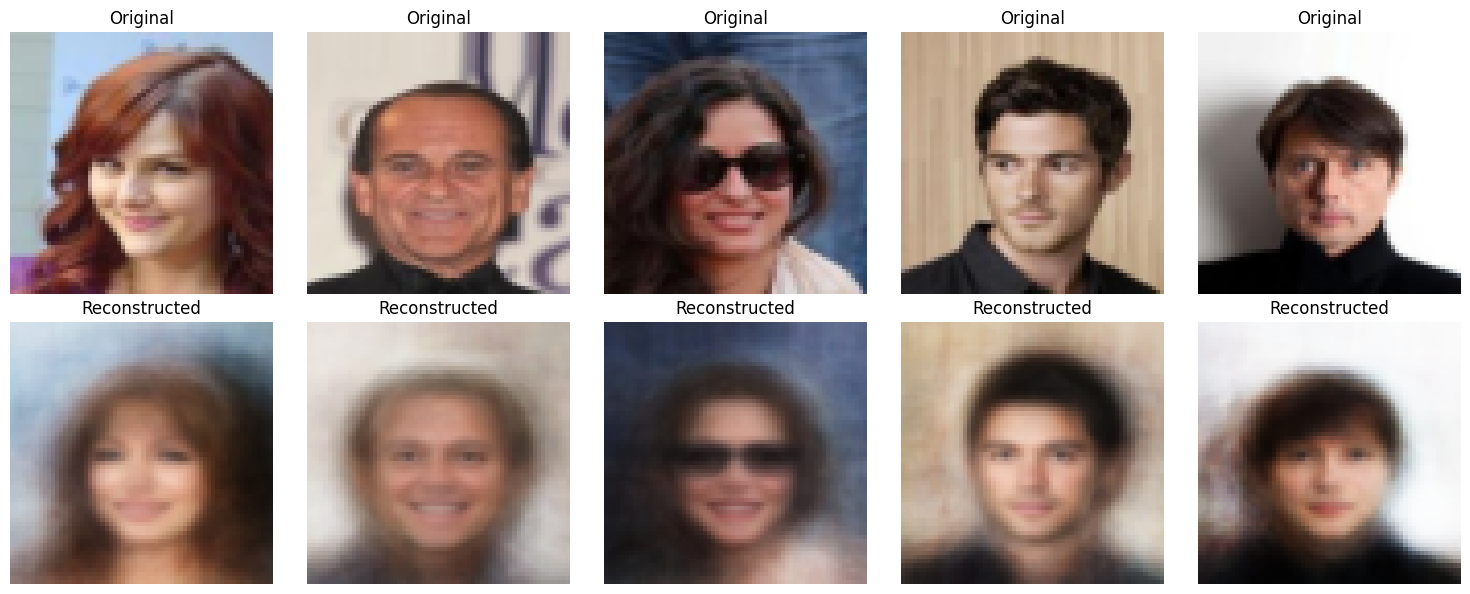

In [33]:
# اجرای تابع برای نمایش مقایسه تصاویر اصلی و بازسازی شده
visualize_results(model, dataloader, num_images=5)

visualize_results with 50 epochs

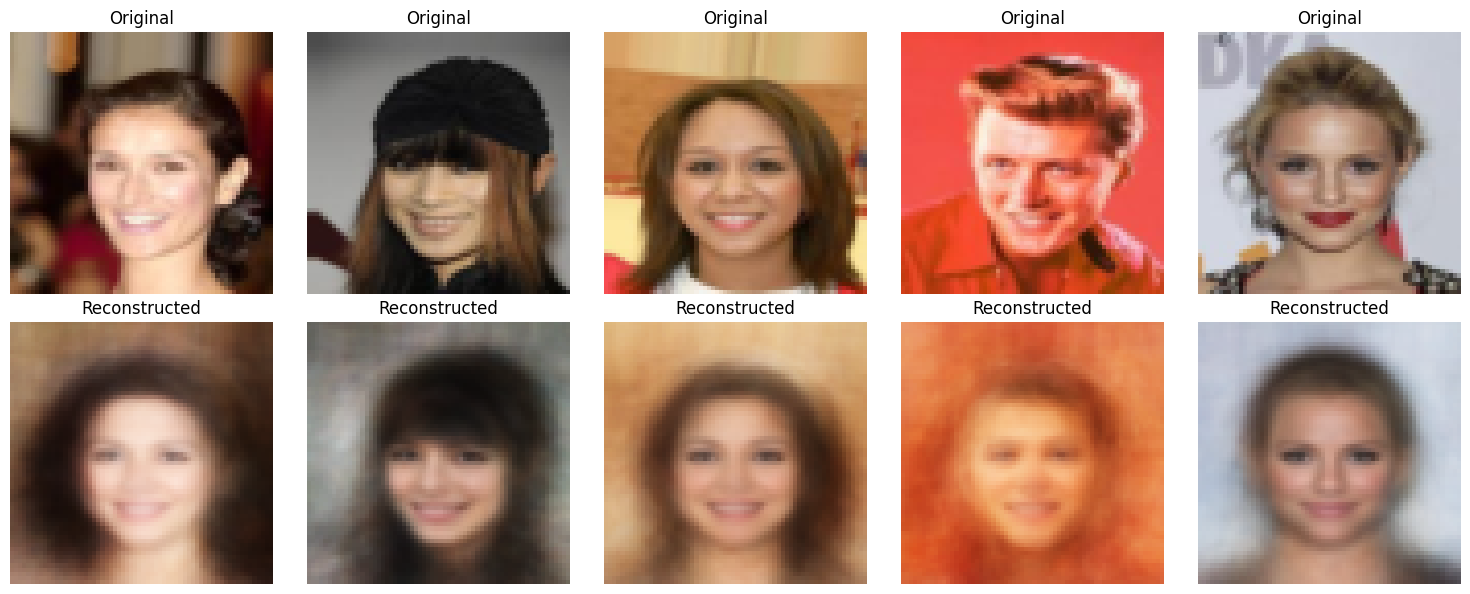

In [40]:
def visualize_results(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        # گرفتن یک دسته از تصاویر واقعی
        data, attrs = next(iter(dataloader))
        data, attrs = data.to(device), attrs.to(device)

        # بازسازی تصاویر توسط مدل
        recon, mu, logvar = model(data, attrs)

        # رسم تصاویر اصلی در مقابل بازسازی شده
        fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
        for i in range(num_images):
            # تصویر اصلی
            orig = data[i].cpu().numpy().transpose(1, 2, 0)
            axes[0, i].imshow(orig)
            axes[0, i].axis('off')
            axes[0, i].set_title("Original")

            # تصویر بازسازی شده
            res = recon[i].view(3, 64, 64).cpu().numpy().transpose(1, 2, 0)
            axes[1, i].imshow(res)
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed")

        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/CVAE_Results/reconstruction_results50.png')
        plt.show()

# برای اجرا: بعد از اتمام آموزش این خط را از کامنت خارج کن:
visualize_results(model, dataloader, num_images=5)

generate_custom_faces with 20 epochs

تولید تصاویر با ویژگی‌های: Blond_Hair, Smiling, Male, Young


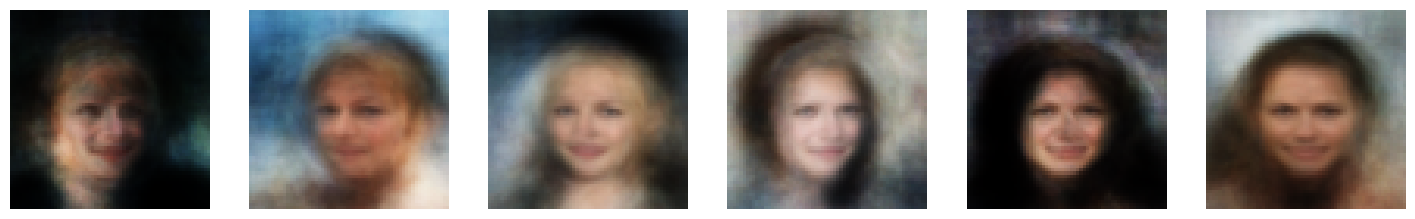

In [34]:
import matplotlib.pyplot as plt
import torch

def generate_custom_faces(model, feature_dict, num_samples=6):
    model.eval()
    # ایجاد یک بردار ویژگی ۴۰ تایی (همه صفر)
    all_attr_names = attr_df.columns[1:].tolist() # لیست نام ویژگی‌ها
    feat_tensor = torch.zeros(1, 40).to(device)

    # اعمال ویژگی‌های مد نظر تو
    applied_features = []
    for name, value in feature_dict.items():
        if name in all_attr_names:
            idx = all_attr_names.index(name)
            feat_tensor[0, idx] = value
            applied_features.append(name)

    fig, axes = plt.subplots(1, num_samples, figsize=(18, 4))
    print(f"تولید تصاویر با ویژگی‌های: {', '.join(applied_features)}")

    with torch.no_grad():
        for i in range(num_samples):
            # ایجاد نویز تصادفی برای فضای پنهان (Latent Space)
            z = torch.randn(1, 128).to(device)

            # تولید تصویر توسط دکودر
            h3 = F.relu(model.fc3(torch.cat([z, feat_tensor], dim=1)))
            h3 = model.att_dec(h3) # اعمال لایه Attention (بهبود تو)
            recon = torch.sigmoid(model.fc4(h3))

            img = recon.view(3, 64, 64).cpu().numpy().transpose(1, 2, 0)
            axes[i].imshow(img)
            axes[i].axis('off')

    plt.savefig('/content/drive/MyDrive/CVAE_Results/generated_faces.png')
    plt.show()

# --- تست: اینجا صفت‌ها را تغییر بده ---
# مثلا: موی بلوند، لبخند، زن (Male=0 یعنی زن)
my_features = {
    'Blond_Hair': 1,
    'Smiling': 1,
    'Male': 0,
    'Young': 1
}

generate_custom_faces(model, my_features)

generate_custom_faces with 50 epochs

تولید تصاویر با ویژگی‌های: Blond_Hair, Smiling, Male, Young


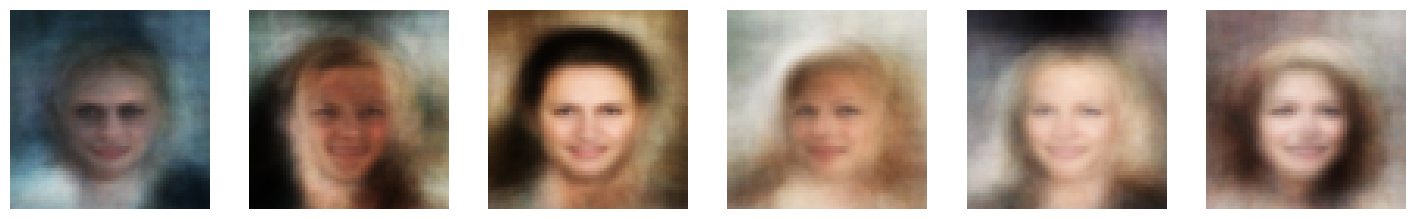

In [41]:
import matplotlib.pyplot as plt
import torch

def generate_custom_faces(model, feature_dict, num_samples=6):
    model.eval()
    # ایجاد یک بردار ویژگی ۴۰ تایی (همه صفر)
    all_attr_names = attr_df.columns[1:].tolist() # لیست نام ویژگی‌ها
    feat_tensor = torch.zeros(1, 40).to(device)

    # اعمال ویژگی‌های مد نظر تو
    applied_features = []
    for name, value in feature_dict.items():
        if name in all_attr_names:
            idx = all_attr_names.index(name)
            feat_tensor[0, idx] = value
            applied_features.append(name)

    fig, axes = plt.subplots(1, num_samples, figsize=(18, 4))
    print(f"تولید تصاویر با ویژگی‌های: {', '.join(applied_features)}")

    with torch.no_grad():
        for i in range(num_samples):
            # ایجاد نویز تصادفی برای فضای پنهان (Latent Space)
            z = torch.randn(1, 128).to(device)

            # تولید تصویر توسط دکودر
            h3 = F.relu(model.fc3(torch.cat([z, feat_tensor], dim=1)))
            h3 = model.att_dec(h3) # اعمال لایه Attention (بهبود تو)
            recon = torch.sigmoid(model.fc4(h3))

            img = recon.view(3, 64, 64).cpu().numpy().transpose(1, 2, 0)
            axes[i].imshow(img)
            axes[i].axis('off')

    plt.savefig('/content/drive/MyDrive/CVAE_Results/generated_faces50.png')
    plt.show()

# --- تست: اینجا صفت‌ها را تغییر بده ---
# مثلا: موی بلوند، لبخند، زن (Male=0 یعنی زن)
my_features = {
    'Blond_Hair': 1,
    'Smiling': 1,
    'Male': 0,
    'Young': 1
}

generate_custom_faces(model, my_features)

other scenarios with 20 epochs

در حال تولید سناریوهای مختلف برای بخش نتایج مقاله...
تولید تصاویر با ویژگی‌های: Male, No_Beard, Attractive, Young


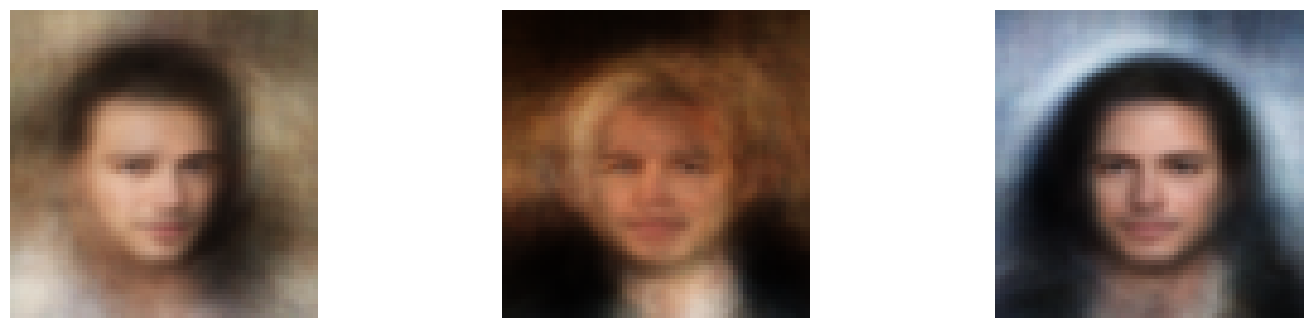

تولید تصاویر با ویژگی‌های: Male, Blond_Hair, Smiling, Heavy_Makeup


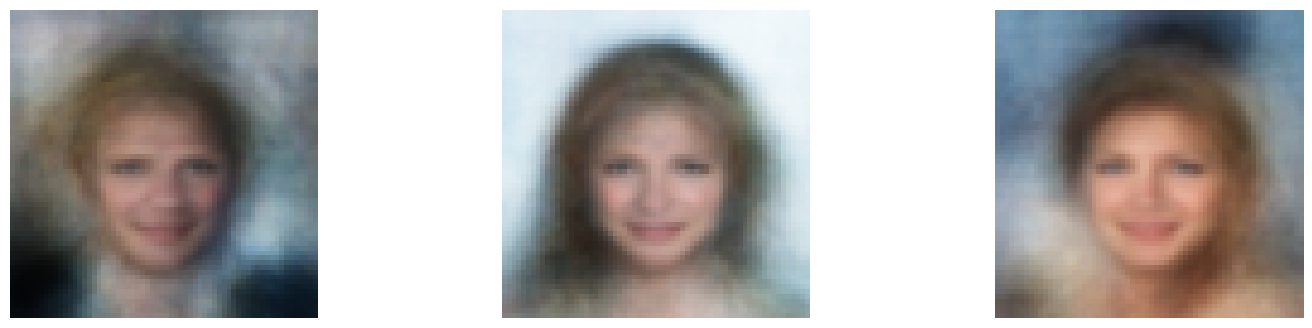

تولید تصاویر با ویژگی‌های: Eyeglasses, Black_Hair, Young


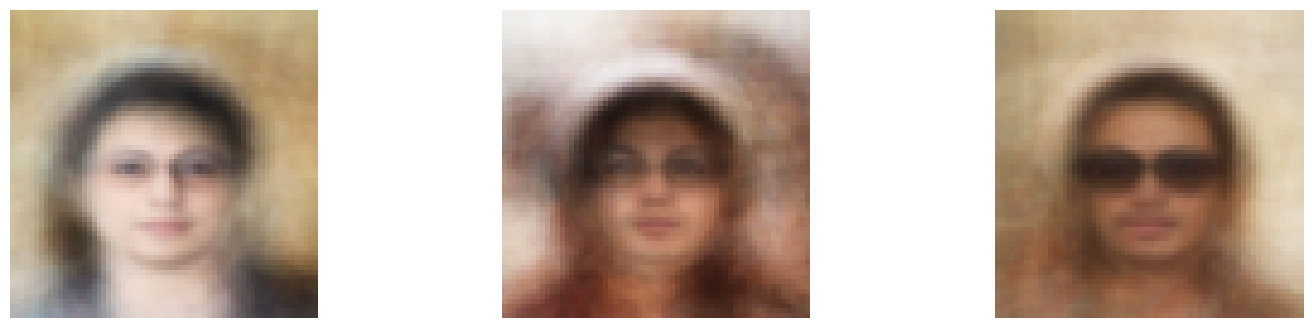

In [35]:
# سناریو ۱: مرد، با ریش و جذاب
scen1 = {'Male': 1, 'No_Beard': 0, 'Attractive': 1, 'Young': 1}

# سناریو ۲: زن، با موی بلوند و لبخند
scen2 = {'Male': 0, 'Blond_Hair': 1, 'Smiling': 1, 'Heavy_Makeup': 1}

# سناریو ۳: فرد عینکی با موی مشکی
scen3 = {'Eyeglasses': 1, 'Black_Hair': 1, 'Young': 1}

print("در حال تولید سناریوهای مختلف برای بخش نتایج مقاله...")
generate_custom_faces(model, scen1, num_samples=3)
generate_custom_faces(model, scen2, num_samples=3)
generate_custom_faces(model, scen3, num_samples=3)

In [42]:
def generate_custom_faces(model, feature_dict, filename, num_samples=6):
    model.eval()
    all_attr_names = attr_df.columns[1:].tolist()
    feat_tensor = torch.zeros(1, 40).to(device)

    applied_features = []
    for name, value in feature_dict.items():
        if name in all_attr_names:
            idx = all_attr_names.index(name)
            feat_tensor[0, idx] = value
            applied_features.append(name)

    fig, axes = plt.subplots(1, num_samples, figsize=(18, 4))

    with torch.no_grad():
        for i in range(num_samples):
            z = torch.randn(1, 128).to(device)
            # استفاده از لایه Attention که در معماری اضافه کردیم
            h3 = F.relu(model.fc3(torch.cat([z, feat_tensor], dim=1)))
            h3 = model.att_dec(h3)
            recon = torch.sigmoid(model.fc4(h3))

            img = recon.view(3, 64, 64).cpu().numpy().transpose(1, 2, 0)
            axes[i].imshow(img)
            axes[i].axis('off')

    # ذخیره با نام اختصاصی در درایو
    full_path = f'/content/drive/MyDrive/CVAE_Results/scenarios50.png'
    plt.savefig(full_path)
    print(f"ذخیره شد در: {full_path}")
    plt.show()

other scenarios with 50 epochs

ذخیره شد در: /content/drive/MyDrive/CVAE_Results/scenarios50.png


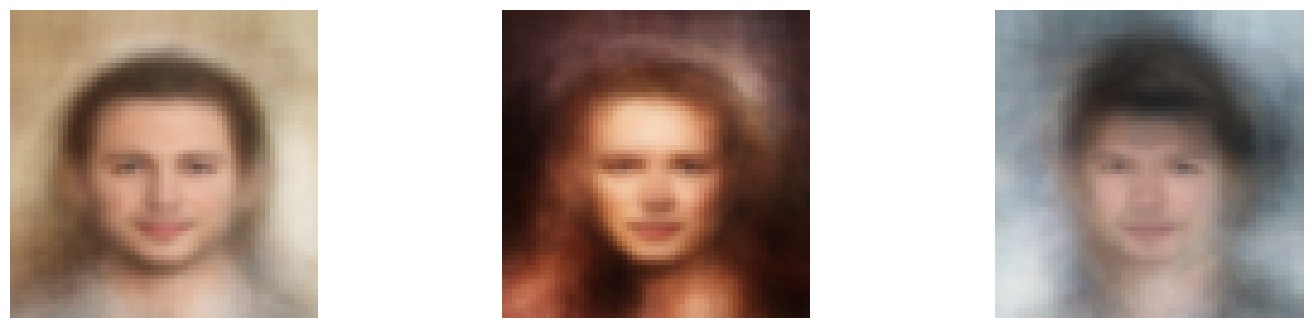

ذخیره شد در: /content/drive/MyDrive/CVAE_Results/scenarios50.png


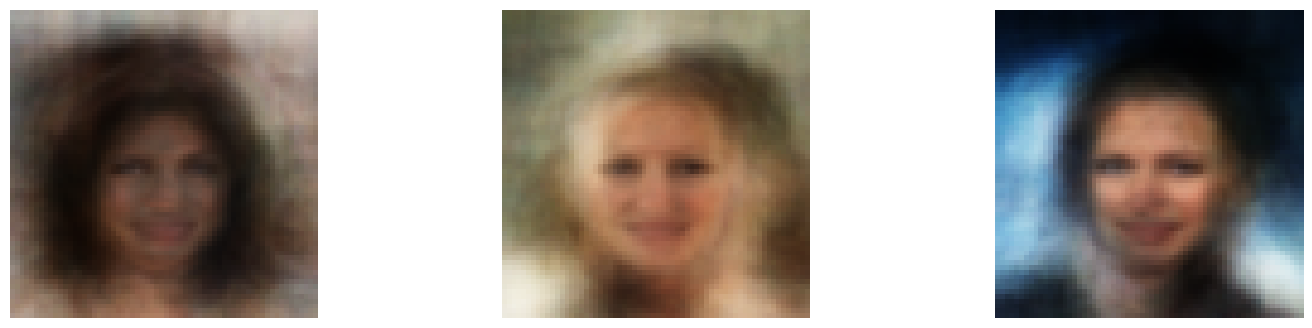

ذخیره شد در: /content/drive/MyDrive/CVAE_Results/scenarios50.png


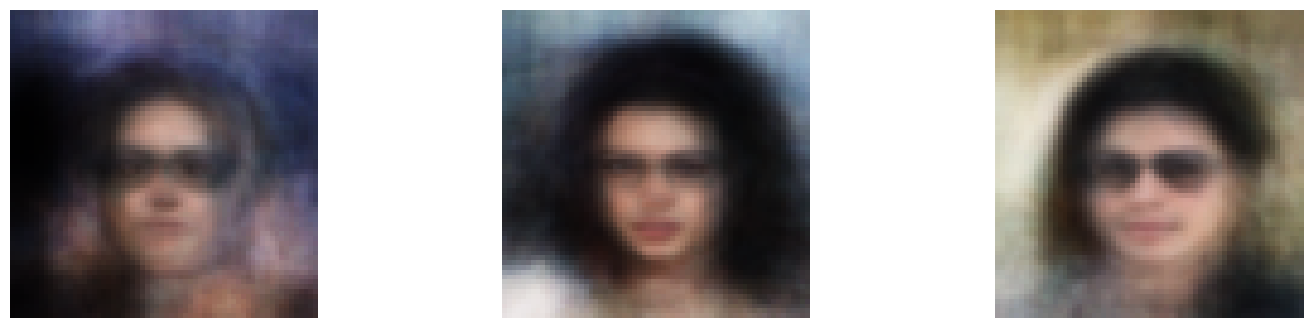

In [43]:
# سناریو ۱: مرد، با ریش و جذاب
scen1 = {'Male': 1, 'No_Beard': 0, 'Attractive': 1, 'Young': 1}
generate_custom_faces(model, scen1, filename='results_male_beard', num_samples=3)

# سناریو ۲: زن، با موی بلوند و لبخند
scen2 = {'Male': 0, 'Blond_Hair': 1, 'Smiling': 1, 'Heavy_Makeup': 1}
generate_custom_faces(model, scen2, filename='results_female_blond', num_samples=3)

# سناریو ۳: فرد عینکی با موی مشکی
scen3 = {'Eyeglasses': 1, 'Black_Hair': 1, 'Young': 1}
generate_custom_faces(model, scen3, filename='results_glasses_black_hair', num_samples=3)

In [36]:
# بارگذاری مدل از درایو بدون نیاز به آموزش دوباره
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/CVAE_Results/cvae_model_epoch_20.pth'))
model.eval()
print("مدلِ آموزش‌دیده با موفقیت از درایو فراخوانی شد!")

مدلِ آموزش‌دیده با موفقیت از درایو فراخوانی شد!


In [44]:
# بارگذاری مدل ۵۰ اپوک (فقط اگر محیط اجرا ریست شده است)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE().to(device)

# تغییر نام فایل به اپوک ۵۰
model_path = '/content/drive/MyDrive/CVAE_Results/cvae_model_epoch_50.pth'

model.load_state_dict(torch.load(model_path))
model.eval()
print("مدلِ نهایی (۵۰ اپوک) با موفقیت بارگذاری شد!")

مدلِ نهایی (۵۰ اپوک) با موفقیت بارگذاری شد!


plot_latent_space with 20 epochs

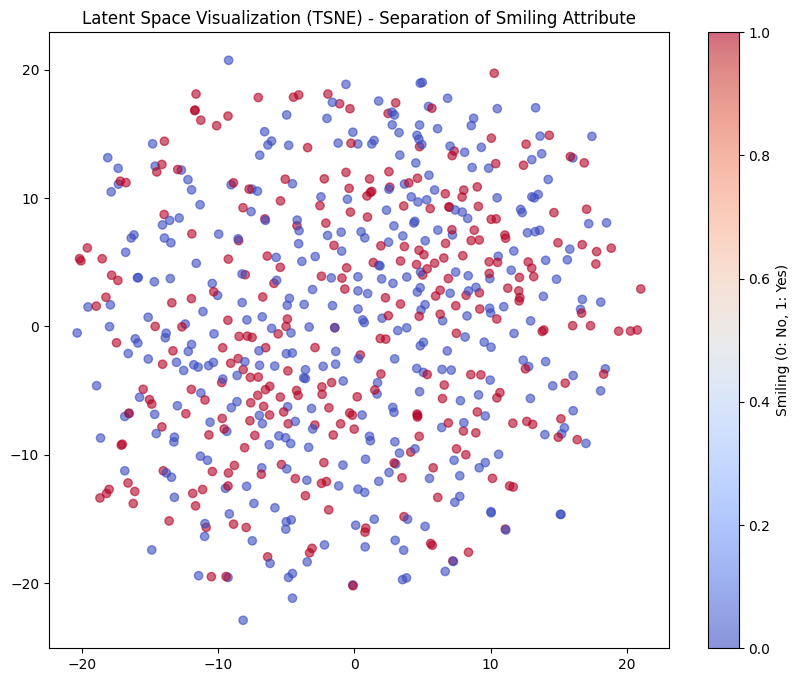

In [37]:
from sklearn.manifold import TSNE
import numpy as np

def plot_latent_space(model, dataloader, num_batches=10):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for i, (data, attrs) in enumerate(dataloader):
            if i >= num_batches: break
            data, attrs = data.to(device), attrs.to(device)
            # گرفتن میانگین (mu) به عنوان نماینده فضای پنهان
            h1 = F.relu(model.fc1(torch.cat([data.view(-1, 64*64*3), attrs], dim=1)))
            h1 = model.att_enc(h1)
            mu, _ = model.fc21(h1), model.fc22(h1)
            latents.append(mu.cpu().numpy())
            labels.append(attrs[:, 31].cpu().numpy()) # ویژگی شماره ۳۱: Smiling

    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    # کاهش ابعاد به ۲ بعد برای رسم نمودار
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label='Smiling (0: No, 1: Yes)')
    plt.title('Latent Space Visualization (TSNE) - Separation of Smiling Attribute')
    plt.savefig('/content/drive/MyDrive/CVAE_Results/latent_space_tsne.png')
    plt.show()

plot_latent_space(model, dataloader)

plot_latent_space with 50 epochs

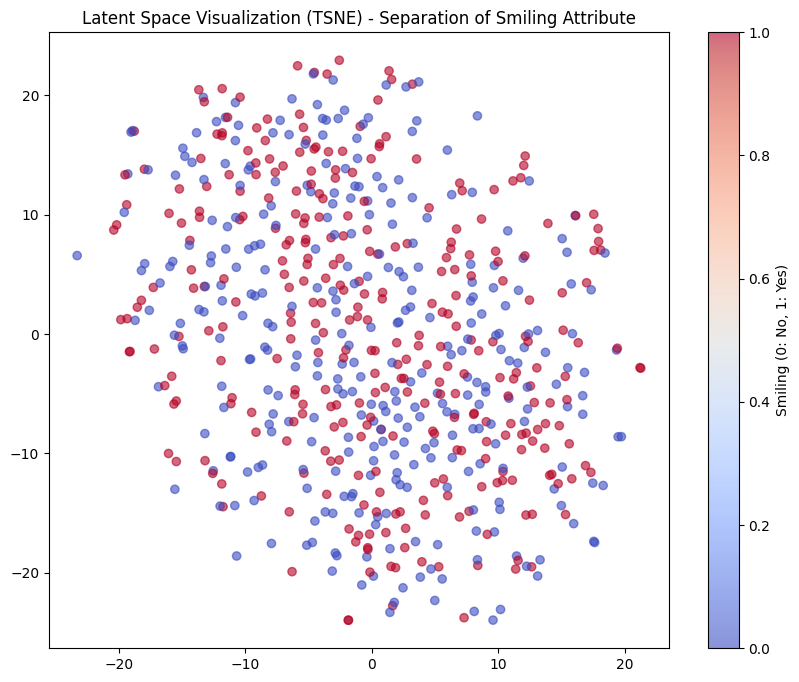

In [45]:
from sklearn.manifold import TSNE
import numpy as np

def plot_latent_space(model, dataloader, num_batches=10):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for i, (data, attrs) in enumerate(dataloader):
            if i >= num_batches: break
            data, attrs = data.to(device), attrs.to(device)
            # گرفتن میانگین (mu) به عنوان نماینده فضای پنهان
            h1 = F.relu(model.fc1(torch.cat([data.view(-1, 64*64*3), attrs], dim=1)))
            h1 = model.att_enc(h1)
            mu, _ = model.fc21(h1), model.fc22(h1)
            latents.append(mu.cpu().numpy())
            labels.append(attrs[:, 31].cpu().numpy()) # ویژگی شماره ۳۱: Smiling

    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    # کاهش ابعاد به ۲ بعد برای رسم نمودار
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label='Smiling (0: No, 1: Yes)')
    plt.title('Latent Space Visualization (TSNE) - Separation of Smiling Attribute')
    plt.savefig('/content/drive/MyDrive/CVAE_Results/latent_space_tsne50.png')
    plt.show()

plot_latent_space(model, dataloader)